# Testing different dynamical systems-inspired training strategies for RNNs and NeuralODEs

We will start out by using the Lorenz63 system:

\begin{aligned}
&\dot{x} = \sigma(y-x)\\
&\dot{y} = x(\rho-z)-y\\
&\dot{z} = xy-\beta z
\end{aligned}

with the parameters $\sigma = 10, \beta = 8/3, \rho = 28$ chosen so that the system displays chaotic behavior.

Following Hess et al. Generalized Teacher Forcing for Learning Chaotic Dynamics, ICML (2023)., the train and test sets are each comprised of a single trajectory 
with initial condition chosen as $\boldsymbol{u_0} = (x_0, y_0, z_0)^T \sim \mathscr{N}(\boldsymbol{0}, \boldsymbol{I})$ with $t=\{i\Delta t\}_{i=0}^{N-1}$ with $\Delta t = 0.01$ and $N=10^5$.

The training set is contaminated with Gaussian observation noise corresponding to 5% of the data standard deviation.

In [19]:
from collections.abc import Callable
from functools import partial

import jax
import jax.numpy as jnp
import equinox as eqx
import diffrax as dfx
from jaxtyping import Float, Array
import matplotlib.pyplot as plt


jax.config.update("jax_enable_x64", True)


In [17]:
class Lorenz63(eqx.Module):
    sigma: float = 10
    beta: float = 8 / 3
    rho: float = 28

    @eqx.filter_jit
    def rhs(self, t, u, args):
        del t, args
        x, y, z = u
        dx = self.sigma * (y - x)
        dy = x * (self.rho - z) - y
        dz = x * y - self.beta * z
        return jnp.stack([dx, dy, dz], axis=0)


lorenz = Lorenz63()


@eqx.filter_jit
def solve_ode(
    ode: Callable,
    u0: Float[Array, " D"],
    t: Float[Array, " N"],
    solver: dfx.AbstractAdaptiveSolver = dfx.Tsit5(),
    rtol: float = 1e-4,
    atol: float = 1e-4,
    **diffeqsolve_kwargs,
) -> Float[Array, "N D"]:
    sol = dfx.diffeqsolve(
        dfx.ODETerm(ode),
        solver,
        t[0],
        t[-1],
        None,
        u0,
        saveat=dfx.SaveAt(ts=t),
        stepsize_controller=dfx.PIDController(rtol=rtol, atol=atol),
        **diffeqsolve_kwargs,
    )
    return sol.ys


key = jax.random.PRNGKey(0)
u0_train_test = jax.random.normal(key, shape=(2, 3))

dt = 0.01
t = jnp.arange(1e5) * dt
solve_lorenz = partial(solve_ode, lorenz.rhs, t=t, max_steps=None)

u_train_test = eqx.filter_vmap(solve_lorenz)(u0_train_test)


In [53]:
u_train_mean = jnp.mean(u_train_test[0], axis=0)
u_train_std = jnp.std(u_train_test[0], axis=0)
u_train_test_norm = (u_train_test - u_train_mean) / u_train_std

u_train, u_test = u_train_test_norm

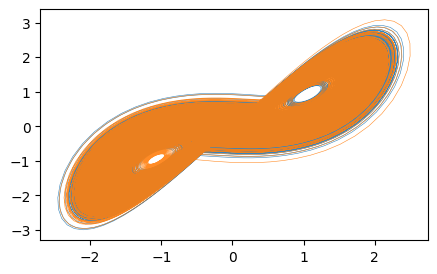

In [54]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
plot_kwargs = {"linewidth": 0.4, "alpha": 0.9}
ax.plot(u_train[:, 0], u_train[:, 1], **plot_kwargs)
ax.plot(u_test[:, 0], u_test[:, 1], **plot_kwargs)

In [55]:
class NeuralODE(eqx.Module):
    in_size: int
    width_size: int
    depth: int
    out_size: int | None = None
    activation: Callable = jax.nn.gelu
    key: int = 0
    net: eqx.nn.MLP = eqx.field(init=False)

    def __post_init__(self):
        if self.out_size is None:
            self.out_size = self.in_size
        self.net = eqx.nn.MLP(
            in_size=self.in_size,
            out_size=self.out_size,
            width_size=self.width_size,
            depth=self.depth,
            activation=self.activation,
            key=jax.random.PRNGKey(self.key),
        )

    def rhs(self, t, u, args):
        del t, args
        return self.net(u)

In [56]:
chunk_length = 200


def split_into_chunks(
    sequence: Float[Array, " N"], chunk_size: int
) -> tuple[Float[Array, "B N"], Float[Array, " N_remainder"] | None]:
    # TODO: Handle batch dimension in the sequence argument
    # TODO: Implement the case when there are overlaps between chunks, as specified by the overlap: int parameter
    chunks = jnp.split(sequence, jnp.arange(chunk_size, len(sequence), chunk_size))
    if len(chunks[-2]) == len(chunks[-1]):
        batched_chunks = jnp.stack(chunks, axis=0)
        remainder = None
    else:
        batched_chunks = jnp.stack(chunks[:-1], axis=0)
        remainder = chunks[-1]
    return batched_chunks, remainder


t_train_batched, remainder = split_into_chunks(t, 200)
u_train_batched, remainder = split_into_chunks(u_train, 200)
assert remainder is None, (
    "Chunk size does not cleanly divide the sequence into equal-length chunks!"
)
u_train_batched.shape

(500, 200, 3)

In [57]:
neuralode = NeuralODE(3, 32, 3)


@eqx.filter_jit
@partial(eqx.filter_vmap, in_axes=(None, 0, 0))
def solve_neuralode(model, u0, t):
    u_pred = solve_ode(
        model.rhs,
        u0,
        t,
        max_steps=2048,
        adjoint=dfx.RecursiveCheckpointAdjoint(checkpoints=4096),
    )
    return u_pred


u_pred = solve_neuralode(neuralode, u_train_batched[:, 0], t_train_batched)

In [58]:
u_pred.shape

(500, 200, 3)

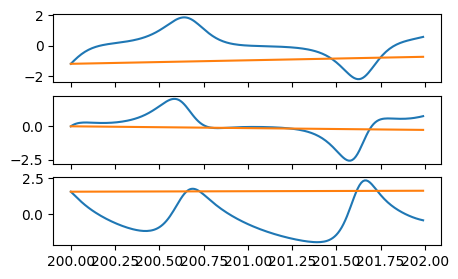

In [59]:
chunk_idx = 100
fig, axes = plt.subplots(3, 1, figsize=(5, 3), sharex=True)
for i, ax in enumerate(axes):
    ax.plot(t_train_batched[chunk_idx], u_train_batched[chunk_idx, :, i])
    ax.plot(t_train_batched[chunk_idx], u_pred[chunk_idx, :, i])